In [1]:
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install tqdm


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!git clone https://github.com/michal-boguslawski/Vision-models-pytorch
!mv Vision-models-pytorch vision_models_pytorch

fatal: destination path 'Vision-models-pytorch' already exists and is not an empty directory.
mv: cannot move 'Vision-models-pytorch' to 'vision_models_pytorch/Vision-models-pytorch': File exists


In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import v2
from tqdm.auto import tqdm
from IPython.display import clear_output 

from vision_models_pytorch.vision_models import *
from vision_models_pytorch.helper_functions import *

## Params

In [37]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
latent_dim = 200

## Get Data

In [38]:
size = 64
transforms = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomResizedCrop((size, size)),
    v2.RandomAffine(degrees=(0, 10), translate=(0., 0.05), scale=(0.9, 1.1)
                   )
                        ])
dataset = torchvision.datasets.OxfordIIITPet('./', download=True, transform=transforms)
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         num_workers=2)

torch.Size([32, 3, 64, 64])


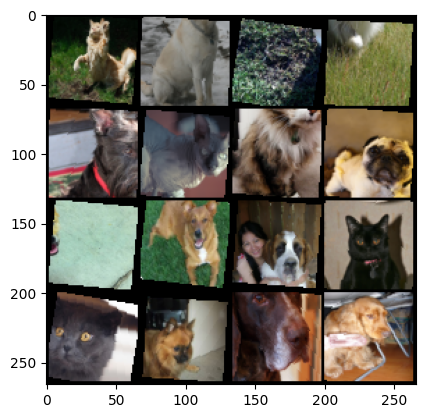

In [21]:
test_image = next(iter(dataloader))[0]
print(test_image.shape)
show_image(test_image[:16])

## Initiate and test models

In [7]:
gen_dims = [1024, 1024, 512, 256, 128]
gen_kernel_sizes = [4, 4, 4, 8]
gen_strides = [2, 2, 2, 4]
gen_paddings = [0, 1, 1, 2]
generator = SimpleGenerator(latent_dim,
                            gen_dims,
                            gen_kernel_sizes,
                            gen_strides,
                            gen_paddings,
                            new_size=(size, size),
                            device=device)

disc_dims = [128, 256, 512]
disc_kernel_sizes = [8, 4, 4]
disc_strides = [4, 2, 2]
disc_paddings = [2, 1, 1]
disc_if_pools = [True, False, True]
discriminator = SimpleDiscriminator(disc_dims,
                                    disc_kernel_sizes,
                                    disc_strides,
                                    disc_paddings,
                                    disc_if_pools,
                                    device=device)

torch.Size([16, 3, 64, 64]) torch.Size([16, 1])


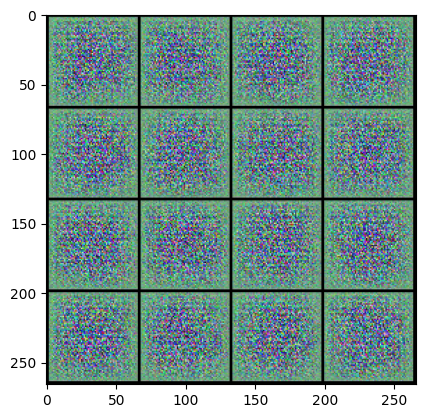

In [8]:
noise = torch.randn(16, latent_dim, device=device)
fake_image = generator(noise).detach()
fake_output = discriminator(fake_image)
print(fake_image.shape, fake_output.shape
      )
show_image(fake_image, rescale=(1, 2))
del fake_image

## Training preparation

In [12]:
learning_rate = 1e-5
gen_optim = optim.AdamW(generator.parameters(), lr=learning_rate, betas=(0.5,0.999))
disc_optim = optim.AdamW(discriminator.parameters(), lr=learning_rate, betas=(0.5,0.999))
loss_fn = WGANLoss # nn.BCEWithLogitsLoss()

## Training

In [ ]:
#step = 0
#del disc_loss, disc_loss_mean, gen_loss
show_step = 35
epochs = int(1e5)
#disc_loss_list = []
#gen_loss_list = []
#args_list = []
n_disc = 1
n_gen = 1
import gc
torch.cuda.empty_cache()
gc.collect()
#show_step_function(epoch, step, show_step, generator, disc_loss_list, gen_loss_list)
for epoch in range(epochs):
  for true_image, _ in tqdm(dataloader):
    true_image = true_image.to(device)
    true_image = true_image * 2 - 1
    disc_loss_mean = 0
    for _ in range(n_disc):
        disc_optim.zero_grad()
        disc_loss, args = training_step_discriminator(true_image, generator, discriminator, loss_fn, latent_dim, device)
        disc_loss.backward()
        disc_optim.step()
        disc_loss_mean += disc_loss.item()/n_disc
        args_list.append(args)
    disc_loss_list.append(disc_loss_mean)

    gen_loss_mean = 0
    for _ in range(n_gen):
      gen_optim.zero_grad()
      gen_loss = training_step_generator(len(true_image), generator, discriminator, loss_fn, latent_dim, device)
      gen_loss.backward()
      gen_optim.step()
      gen_loss_mean += gen_loss.item()/n_gen
    gen_loss_list.append(gen_loss_mean)

    step += 1
    if step % 1000 == 0:
        clear_output()
    if step % show_step == 0:
      show_step_function(epoch, latent_dim, step, show_step, generator, disc_loss_list, gen_loss_list, if_quantile=True, device=device)


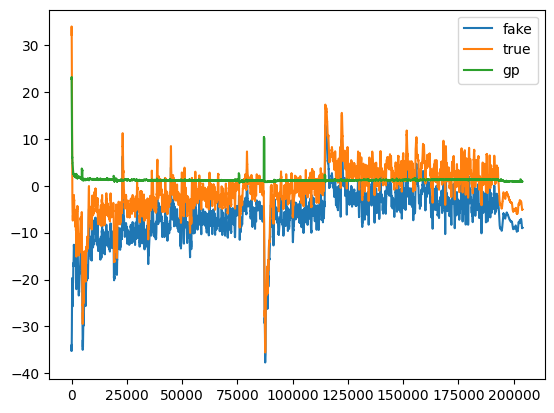

In [42]:
arr = np.asarray(args_list)
window_size = 300
weights = np.ones(window_size) / window_size
moving_avg = np.convolve(arr[:, 0], weights, mode='valid')
plt.plot(range(len(moving_avg)),
         moving_avg,
        label='fake')
moving_avg = np.convolve(arr[:, 1], weights, mode='valid')
plt.plot(range(len(moving_avg)),
         moving_avg,
        label='true')
moving_avg = np.convolve(arr[:, 2], weights, mode='valid')
plt.plot(range(len(moving_avg)),
         moving_avg,
        label='gp')
plt.legend()


Epoch: 160, Step: 48276, Discriminator loss last 35: -2.832950626100813,     Generator loss last 35: 9.212421635219028


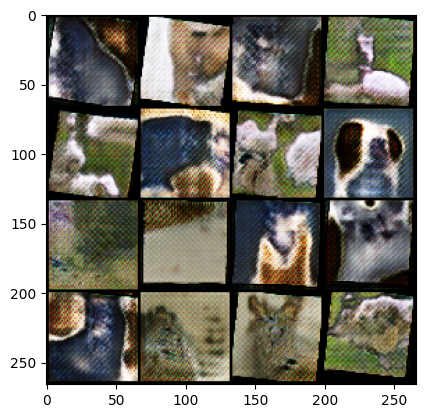

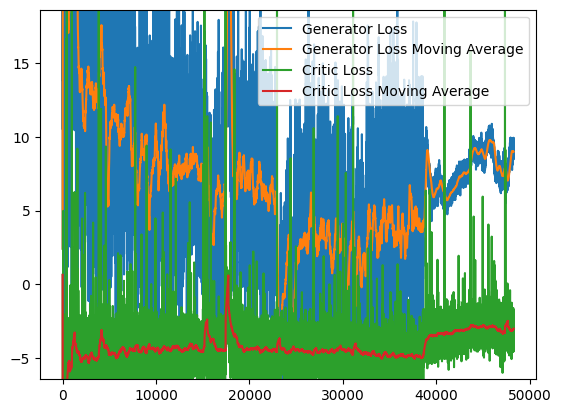

In [43]:

torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()   # Total reserved memory
with torch.no_grad():
    show_step_function(epoch, latent_dim, step, show_step, generator, disc_loss_list, gen_loss_list, if_quantile=True, device=device)